In [245]:
# !pip install plotly tensorflow

In [246]:
import pandas as pd 
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout, SimpleRNN
import tensorflow as tf
import math

In [247]:
df_train = pd.read_csv("./Google/trainset.csv")
df_test = pd.read_csv("./Google/testset.csv")

In [248]:
df = pd.concat([df_train, df_test ])

In [249]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/2013,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,03/01/2013,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,04/01/2013,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,07/01/2013,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,08/01/2013,365.393463,365.771027,359.874359,364.280701,364.280701,3373900
5,09/01/2013,363.769043,366.789398,361.945892,366.675140,366.675140,4075700
6,10/01/2013,369.014923,370.092896,364.380066,368.344269,368.344269,3695100
7,11/01/2013,368.602600,368.816193,365.771027,367.604095,367.604095,2587000
8,14/01/2013,366.118744,368.701935,358.841095,359.288177,359.288177,5765000
9,15/01/2013,357.340851,365.125214,353.749207,360.122742,360.122742,7906300


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1509 entries, 0 to 124
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1509 non-null   object 
 1   Open       1509 non-null   float64
 2   High       1509 non-null   float64
 3   Low        1509 non-null   float64
 4   Close      1509 non-null   float64
 5   Adj Close  1509 non-null   float64
 6   Volume     1509 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 94.3+ KB


In [251]:
df.isnull().sum().any()

False

In [252]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03
mean,725.421046,731.328923,719.166879,725.453745,725.453745,2.309161e+06
std,229.684153,232.051036,227.618669,229.941489,229.941489,1.573016e+06
min,350.053253,350.391052,345.512787,349.164032,349.164032,7.900000e+03
25%,536.650024,540.000000,532.409973,536.690002,536.690002,1.327100e+06
50%,706.859985,713.239990,698.106995,705.840027,705.840027,1.776000e+06
75%,929.400024,933.479980,923.030029,929.080017,929.080017,2.771800e+06
max,1177.329956,1186.890015,1171.979980,1175.839966,1175.839966,2.328310e+07


In [253]:
df.shape

(1509, 7)

In [254]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [255]:
df["Date"]=pd.to_datetime(df.Date, dayfirst=True)
df.set_index("Date",inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900
...,...,...,...,...,...,...
2018-06-25,1143.599976,1143.910034,1112.780029,1124.810059,1124.810059,2157300
2018-06-26,1128.000000,1133.209961,1116.659058,1118.459961,1118.459961,1563200
2018-06-27,1121.339966,1131.836060,1103.619995,1103.979980,1103.979980,1293900


In [256]:
# Data Correlation: Relationship between columns
df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999701,0.999545,0.999193,0.999193,-0.431205
High,0.999701,1.000000,0.999500,0.999578,0.999578,-0.426777
Low,0.999545,0.999500,1.000000,0.999684,0.999684,-0.438024
Close,0.999193,0.999578,0.999684,1.000000,1.000000,-0.433302
Adj Close,0.999193,0.999578,0.999684,1.000000,1.000000,-0.433302
Volume,-0.431205,-0.426777,-0.438024,-0.433302,-0.433302,1.000000


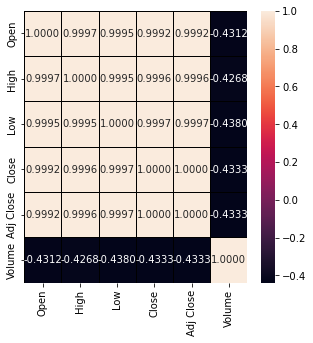

In [257]:
# Visualization of correlation result with seaborn library heatmap.
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(df.corr(), annot = True, linewidths=0.5, linecolor = "black", fmt = ".4f", ax = ax)
plt.show()

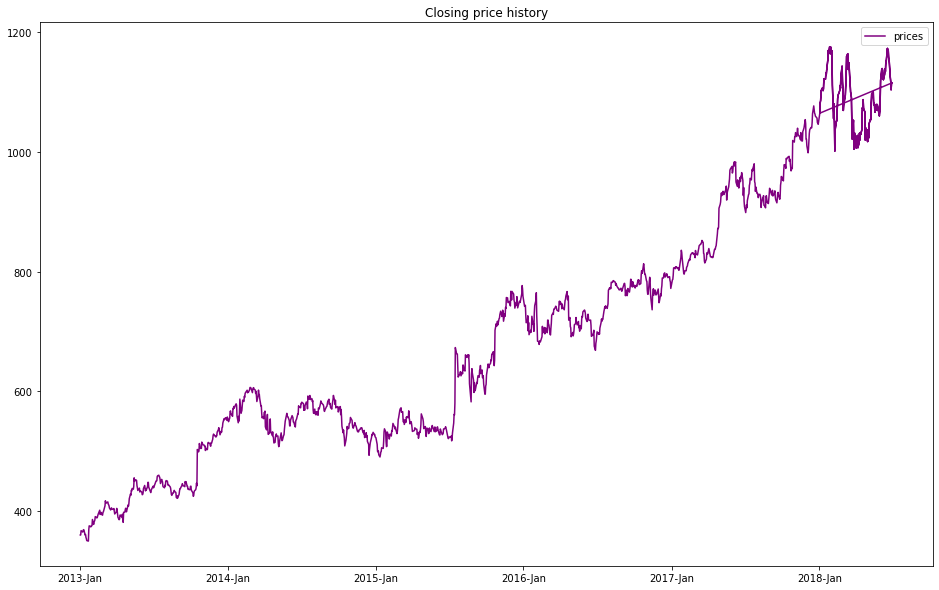

In [258]:
plt.figure(figsize=(16,10))

plt.title('Closing price history')
plt.plot(df['Close'],label='prices', color='purple')
# plt.plot(df_dp['Date'],df_dp['Close'],label='Max Temp.')
plt.legend()
####### Use the below functions #######
dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.show()

In [259]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [260]:
# dft = df.copy()
col_to_keep = ['Close', 'High', 'Low', ]

for col in df.columns:
    if col not in col_to_keep:
        del df[col]

<AxesSubplot:title={'center':'Stock Prices'}, xlabel='Date'>

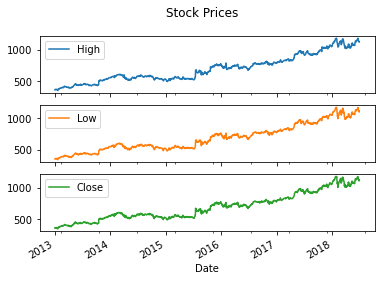

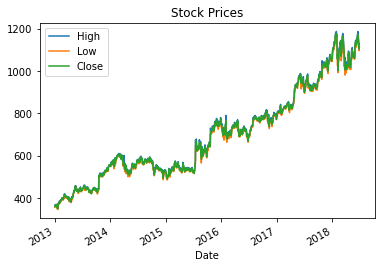

In [261]:
df.plot.line(subplots=True, title='Stock Prices')
df.plot.line(title='Stock Prices')

In [262]:
data = df.filter(['Close'])
dataset = data.values

In [263]:
dataset

array([[ 359.288177],
       [ 359.496826],
       [ 366.600616],
       ...,
       [1103.97998 ],
       [1114.219971],
       [1115.650024]])

In [264]:
# train_app_len = int(dfa.shape[0]*0.75)
train_len = math.ceil(len(df)*.75)
train_len

1132

In [265]:
ms = MinMaxScaler(feature_range=(0,1))
scaled_df = ms.fit_transform(dataset)

In [266]:
# creating the training dataset
train_df = scaled_df[0:train_len, :]
X_train, y_train= [], []

for x in range(60, len(train_df)):
    X_train.append(train_df[x-60:x, 0])
    y_train.append(train_df[x, 0])

In [267]:
X_train=np.array(X_train)
y_train=np.array(y_train)

In [268]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [269]:
X_train.shape

(1072, 60, 1)

In [270]:
def plot_scaled(dfd, title):
    plt.plot(dfd)
    plt.ylabel("Price")
    plt.xlabel("Time(Days)")
    plt.title(f"{title} Stock Data")
    plt.show()

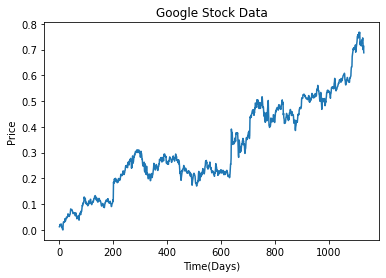

In [271]:
plot_scaled(train_df, title="Google")

# Model Definition

In [272]:
def RNNMODEL(X_train=[], Y_train=[]):
    # Initialising the RNN
    regressor = Sequential()

    # Add the first RNN layer and some Dropout regularisation
    regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Second RNN layer and some Dropout regularisation
    regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
    regressor.add(Dropout(0.2))

    # Third RNN layer and some Dropout regularisation
    regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
    regressor.add(Dropout(0.2))

    # Fourth RNN layer and some Dropout regularisation
    regressor.add(SimpleRNN(units = 50))
    regressor.add(Dropout(0.2))

    # Add the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = "adam", loss = "mean_squared_error")
    regressor.summary()

    # Fitting the RNN to the training set
    regressor.fit(X_train, Y_train, epochs = 100, batch_size = 32)
    
    return regressor

In [303]:
def LSTMMODEL(X_train=[], Y_train=[]): 
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1),  activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(50,  return_sequences=False,  activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(25,  activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.summary()
#     model.fit(X_tr, X_tr, epochs=1, batch_size=1)
    
    model.fit(X_train, Y_train, epochs=100, batch_size=32)
    return model

# RNN ANALYSIS

In [289]:
rnn_model = RNNMODEL(X_train = X_train , Y_train=y_train)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_24 (SimpleRNN)   (None, 60, 50)            2600      
                                                                 
 dropout_24 (Dropout)        (None, 60, 50)            0         
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 60, 50)            5050      
                                                                 
 dropout_25 (Dropout)        (None, 60, 50)            0         
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 60, 50)            5050      
                                                                 
 dropout_26 (Dropout)        (None, 60, 50)            0         
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 50)              

34/34 [==============================] - 2s 71ms/step - loss: 0.0017
Epoch 82/100
34/34 [==============================] - 3s 77ms/step - loss: 0.0014
Epoch 83/100
34/34 [==============================] - 2s 63ms/step - loss: 0.0016
Epoch 84/100
34/34 [==============================] - 2s 62ms/step - loss: 0.0016
Epoch 85/100
34/34 [==============================] - 2s 67ms/step - loss: 0.0016
Epoch 86/100
34/34 [==============================] - 3s 80ms/step - loss: 0.0015
Epoch 87/100
34/34 [==============================] - 2s 61ms/step - loss: 0.0015
Epoch 88/100
34/34 [==============================] - 2s 66ms/step - loss: 0.0014
Epoch 89/100
34/34 [==============================] - 2s 65ms/step - loss: 0.0015
Epoch 90/100
34/34 [==============================] - 2s 60ms/step - loss: 0.0015
Epoch 91/100
34/34 [==============================] - 2s 57ms/step - loss: 0.0013
Epoch 92/100
34/34 [==============================] - 2s 58ms/step - loss: 0.0014
Epoch 93/100
34/34 [=========

In [290]:
test_df = scaled_df[train_len-60: , :]
y_test = dataset[train_len:, :]
X_test = []

for x in range(60, len(test_df)):
    X_test.append(test_df[x-60:x, 0])  

In [291]:
X_test = np.array(X_test)

In [292]:
X_test.shape 

(377, 60)

In [293]:
X_test= np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [294]:
X_test.shape 

(377, 60, 1)

In [295]:
pred = rnn_model.predict(X_test)
pred_stock = ms.inverse_transform(pred)

12/12 [==============================] - 1s 16ms/step


In [296]:
# evaluating the performance of the model
print("RNN GOOGLE R2-Score of LSTM predictions for {0}".format(r2_score(y_test, pred_stock)))
print('RNN GOOGLE Mean Absolute Error:', mean_absolute_error(y_test, pred_stock))
print('RNN GOOGLE Mean Squared Error:', mean_squared_error(y_test, pred_stock))
print('RNN GOOGLE Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, pred_stock)))

RNN GOOGLE R2-Score of LSTM predictions for 0.6915875474373692
RNN GOOGLE Mean Absolute Error: 34.48650942960462
RNN GOOGLE Mean Squared Error: 1686.4573061708795
RNN GOOGLE Mean Root Squared Error: 41.06649858669326


In [297]:
trains = data[:train_len]
valid = data[train_len:]
valid['predictions']=pred_stock

def plot_prediction(trainx, validx, title, subtitle, predictions):
    plt.figure(figsize=(16,8))
    plt.title(f'{title} Prediction With {subtitle}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(f'{title} Stock price in ($)', fontsize=18)
    plt.plot(trainx['Close'], label=f'{title} Predicted Price', linewidth=1.5)
    plt.plot(validx[['Close', 'predictions']], label='Real Apple Price', linewidth=1.5)
    plt.legend(['Train','Valid', 'Prediciton'], loc='lower right')
    plt.show()

C:\Users\WRASH-~1\AppData\Local\Temp/ipykernel_14884/358488486.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



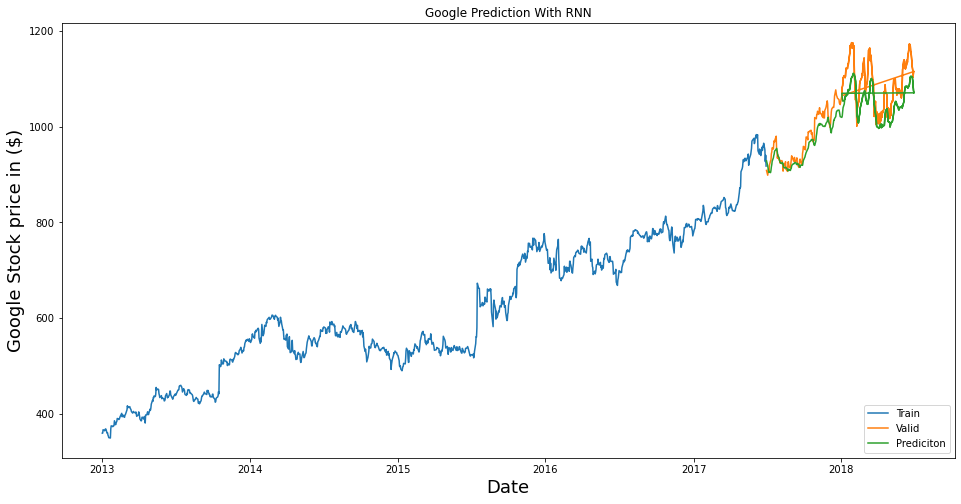

In [298]:
plot_prediction(trainx=trains, validx=valid, title="Google", subtitle="RNN", predictions=pred_stock)

# LSTM ANALYSIS

In [304]:
lstm_model = LSTMMODEL(X_train = X_train , Y_train=y_train)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_28 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_29 (Dropout)        (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 25)                1275      
                                                                 
 dropout_30 (Dropout)        (None, 25)                0         
                                                                 
 dense_18 (Dense)            (None, 1)               

34/34 [==============================] - 2s 70ms/step - loss: 8.1492e-04
Epoch 84/100
34/34 [==============================] - 2s 67ms/step - loss: 7.6300e-04
Epoch 85/100
34/34 [==============================] - 2s 73ms/step - loss: 8.3157e-04
Epoch 86/100
34/34 [==============================] - 2s 68ms/step - loss: 8.2097e-04
Epoch 87/100
34/34 [==============================] - 2s 71ms/step - loss: 8.3475e-04
Epoch 88/100
34/34 [==============================] - 3s 78ms/step - loss: 8.8884e-04
Epoch 89/100
34/34 [==============================] - 2s 72ms/step - loss: 8.2308e-04
Epoch 90/100
34/34 [==============================] - 2s 65ms/step - loss: 8.4538e-04
Epoch 91/100
34/34 [==============================] - 2s 68ms/step - loss: 8.1239e-04
Epoch 92/100
34/34 [==============================] - 2s 71ms/step - loss: 8.5429e-04
Epoch 93/100
34/34 [==============================] - 3s 76ms/step - loss: 7.8895e-04
Epoch 94/100
34/34 [==============================] - 2s 70ms/step 

In [ ]:
pred = lstm_model.predict(X_test)
pred_stock = ms.inverse_transform(pred)

In [ ]:
# Evaluating Model's Performance
print("LSTM GOOGLE R2-Score of LSTM predictions for {0}".format(r2_score(y_test, pred_stock)))
print('LSTM GOOGLE Mean Absolute Error:', mean_absolute_error(y_test, pred_stock))
print('LSTM GOOGLE Mean Squared Error:', mean_squared_error(y_test, pred_stock))
print('LSTM GOOGLE Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, pred_stock)))

In [ ]:
trains = data[:train_len]
valid = data[train_len:]
valid['predictions']=pred_stock

In [ ]:
plot_prediction(trainx=trains, validx=valid, title="Google", subtitle="LSTM", predictions=pred_stock)